In [1]:
import numpy as np
from orphics import maps, cosmology,io,stats
from scipy import optimize
import cosmo_cleaner
import matplotlib.pyplot as plt
from cosmo_cleaner import fisher as fisher,plot
from cosmo_cleaner import cosmology,triangle_plot
import camb
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_theme(style='white')
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200


## Provide forecast between CMB lensing x galaxy cross correlation

Initialize default cosmology

In [2]:
defaultCosmology = {'omch2': 0.1197
                    ,'ombh2': 0.02222
                    ,'H0': 69
                    ,'ns': 0.9655
                    ,'As': 2.1955e-9
                    ,'mnu': 0.06
                    ,'w0': -1.0
                    ,'tau':0.06
                    ,'nnu':3.046
                    ,'wa': 0.,'bias':1,'A_l':1.,'A_e':1,'N_eff':3.046,'omega_e':0.007,'omega_k':0}


nz = 1000
kmax = 10
zmin = 0.
ells=np.arange(3000)
for i in range(16):
    defaultCosmology[f'lsst_bias{i}']=1

nz = 1000
kmax = 10
zmin = 0.
ells=np.arange(3000)

pars = camb.CAMBparams()
pars.set_dark_energy(w=defaultCosmology['w0'],wa = defaultCosmology['wa'], dark_energy_model = 'ppf')
pars.set_cosmology(H0=defaultCosmology['H0'], cosmomc_theta = None,ombh2=defaultCosmology['ombh2'], 
               omch2=defaultCosmology['omch2'],omk=defaultCosmology['omega_k'], mnu=defaultCosmology['mnu'], tau = defaultCosmology['tau'],
               nnu = defaultCosmology['nnu'], num_massive_neutrinos = 3)
pars.InitPower.set_params(ns=defaultCosmology['ns'],As=defaultCosmology['As'])

results = camb.get_results(pars)
default=cosmology.cosmology(nz,kmax,zmin,ells,defaultCosmology,pars,results)

Get the lensing specifications

In [3]:
f_sky=0.4
lensing=cosmology.CMB_Lensing(lens_beam = 7.0,lens_noiseT = 33.,lens_noiseP = 56.,
             lens_tellmin = 2,lens_tellmax = 3000,lens_pellmin = 2,
             lens_pellmax = 3000,lens_kmin = 2,lens_kmax = 3000, lens_f_sky=f_sky) 
#lens_kmin,lens_kmax: Lensing Lmin and Lmax
#lens_tellmin,lens_tellmax: CMB temperature multipoles
#lens_pellmin,lens_pellmax: CMB polarization multipoles


In [4]:
N0=lensing.noise_rec[:3000]

Specify binning: lets use Planck 2018 lensing binning

In [5]:
planck_bins=np.array([8,21,40,66,101,145,199,264,339,426,526,638,763,902,1100,1300,1500,1700,2048])

In [6]:
bins,auto,error,snr=lensing.get_auto_spectra(results,planck_bins)

Text(0, 0.5, '$C^{\\kappa\\kappa}_L$')

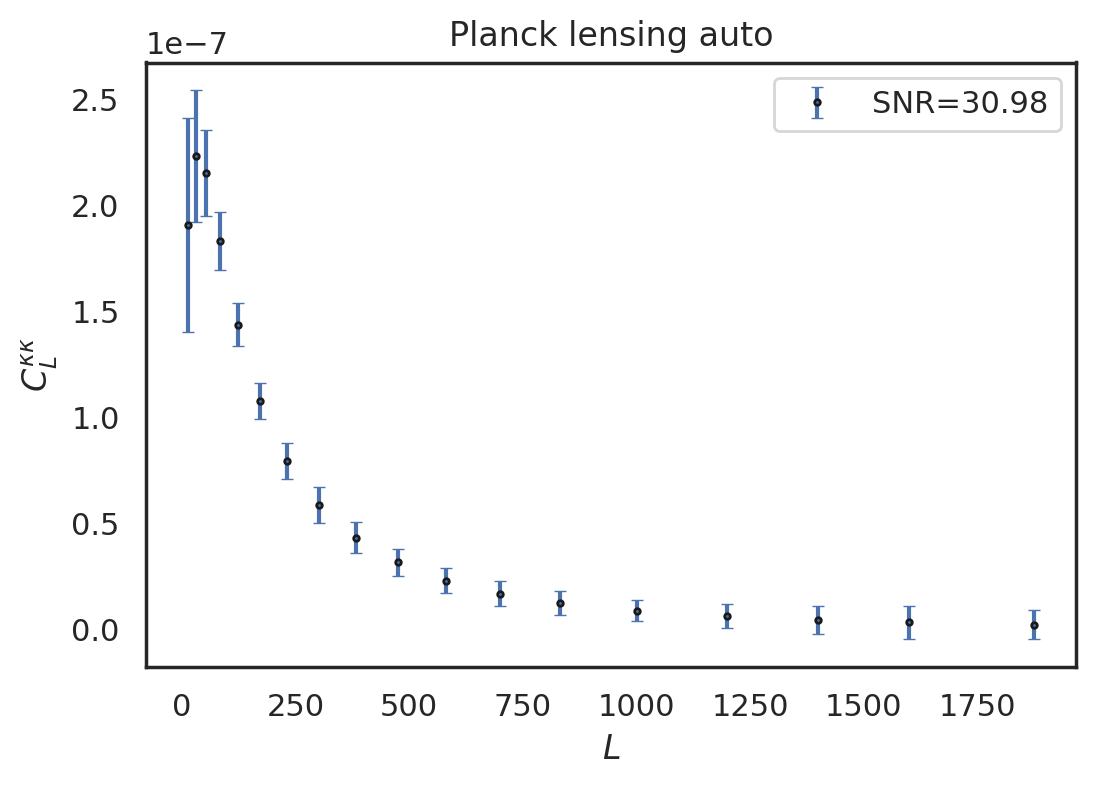

In [7]:
plt.errorbar(bins,auto,yerr=error,fmt='ko', mfc='b',capthick=0.5, ecolor='b', markersize=2 ,capsize=2,label=f'SNR={snr}')
plt.legend()
plt.title('Planck lensing auto')
plt.xlabel('$L$')
plt.ylabel('$C^{\kappa\kappa}_L$')

## get cross correlation with galaxy field (gaussian field with bias $b_i$ and shot noise $1/\bar{n}$)

lets define the galaxy window function $W^g=b_i\frac{dn_i}{dz}$ as a Gaussian

In [97]:
def dndz_gauss(z,z0,sigma,bias):
    ans = 1/np.sqrt(2*np.pi*sigma**2)* np.exp((-(z-z0)**2)/ (2.*sigma**2.))
    return bias*ans

In [98]:
wg_b=dndz_gauss(default.zs,0.6,0.2,0.8)
n=3400 #number density in square degrees
n=n/(np.pi/180.)**2
shotnoise=1/n

(0.0, 2.0)

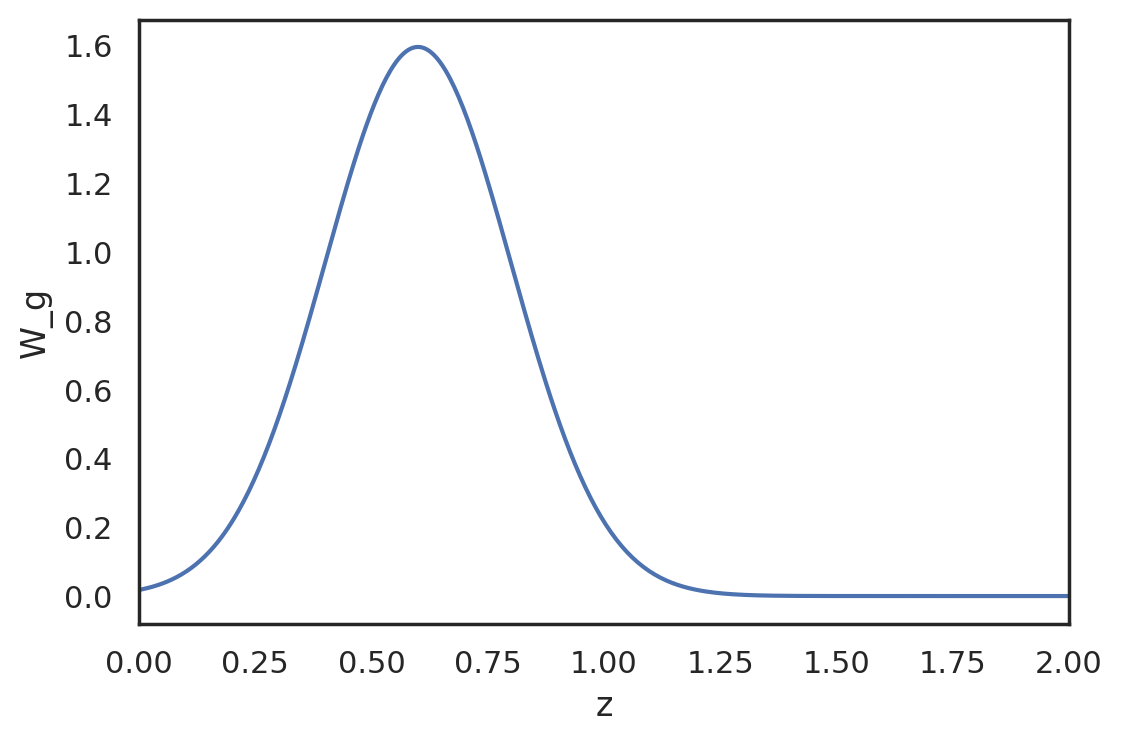

In [99]:
plt.plot(default.zs,wg_b)
plt.ylabel('W_g')
plt.xlabel('z')

plt.xlim(0,2)

Compute $C^{\kappa{g}}_L$ and error $\sigma{(C^{\kappa{g}}_L)}^2=\frac{1}{(2L+1)\Delta{L}f_{\text{sky}}}\Big[\Big(C^{\kappa\kappa}_L+N^{\kappa\kappa}_L\Big)\Big(C^{gg}_L+N^{gg}_L\Big)+(C^{\kappa{g}}_L)^2\Big]$

In [100]:
lbins=np.array([8,21,40,66,101,145,199,264,339])

In [101]:
cents,clkgb,error,snr=default.get_kappa_g_forecast(wg_b,shotnoise,N0[:3000],f_sky,lbins)

Text(0, 0.5, '$C^{\\kappa{g}}_L$')

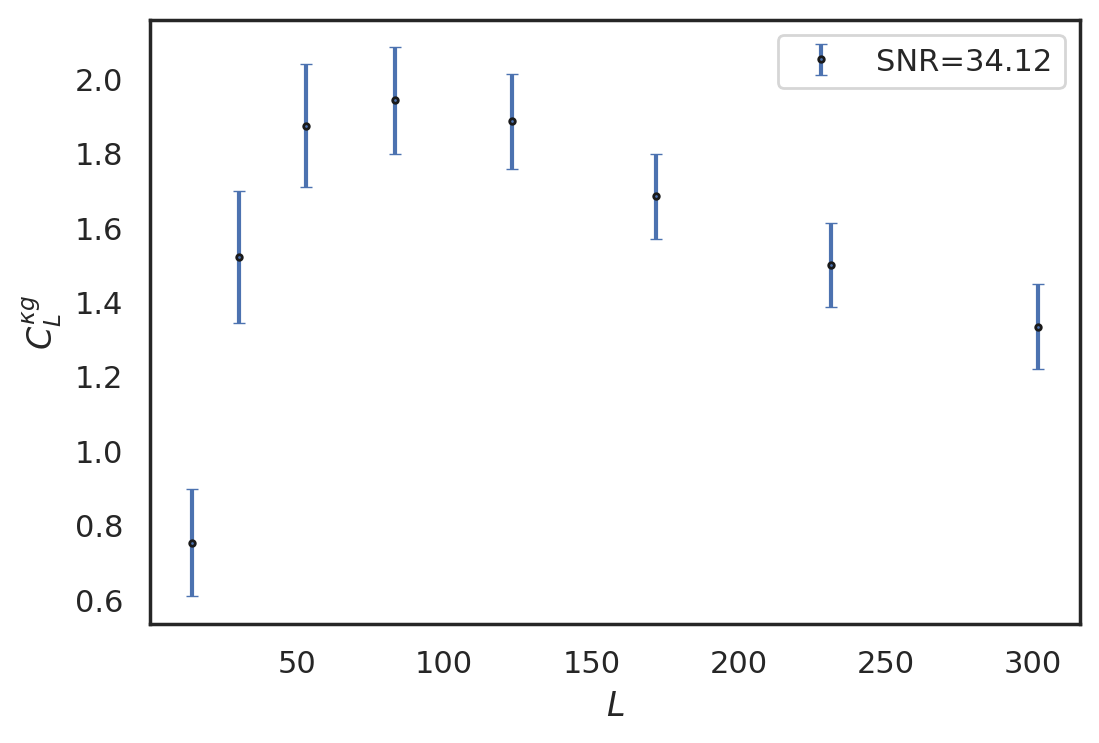

In [102]:
plt.errorbar(cents,10**5*cents*clkgb,yerr=10**5*cents*error,fmt='ko', mfc='b',capthick=0.5, ecolor='b', markersize=2 ,capsize=2,label=f'SNR={snr}')
plt.legend()
plt.xlabel('$L$')
plt.ylabel('$C^{\kappa{g}}_L$')